<a href="https://colab.research.google.com/github/sonpn82/Tensor-flow-Developer-Certification-Exam/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_turning_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning

In [44]:
# Check if we're using a GPU
!nvidia-smi

Mon Jul  4 08:04:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   4884MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we' created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [45]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-04 08:04:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-04 08:04:51 (103 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [46]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

>**Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [47]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-07-04 08:04:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.120.128, 142.251.161.128, 64.233.183.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   235MB/s    in 0.7s    

2022-07-04 08:04:52 (235 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [48]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [49]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [50]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [51]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [52]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [53]:
# See an example of a batch data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.71648605e+02 1.69413269e+02 1.58119263e+02]
   [1.72491074e+02 1.70427933e+02 1.58617340e+02]
   [1.79185577e+02 1.77185577e+02 1.65185577e+02]
   ...
   [2.04771667e+02 1.48650482e+02 7.47110748e+01]
   [2.21585464e+02 1.67711731e+02 9.36485901e+01]
   [2.24397308e+02 1.70867966e+02 9.66326370e+01]]

  [[1.77438126e+02 1.77686874e+02 1.70616074e+02]
   [1.78796555e+02 1.79633926e+02 1.71505096e+02]
   [1.83351395e+02 1.84893494e+02 1.74437500e+02]
   ...
   [2.29057419e+02 1.76985992e+02 1.00985985e+02]
   [2.21822067e+02 1.72628830e+02 9.66932373e+01]
   [2.21200256e+02 1.72064423e+02 9.61096954e+01]]

  [[1.83303574e+02 1.85867996e+02 1.81892853e+02]
   [1.84491074e+02 1.87842484e+02 1.81253189e+02]
   [1.87393494e+02 1.90688766e+02 1.84242355e+02]
   ...
   [2.21239807e+02 1.71705994e+02 9.48839340e+01]
   [2.28496826e+02 1.79071426e+02 1.02187508e+02]
   [2.25626923e+02 1.78198364e+02 1.00412643e+02]]

  ...

  [[4.64356422e+01 2.74356441e+01 1.08641720e+01]
   [4

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [54]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Averate pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compiling the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="10_percent_feature_extraction",
                                                                       ))

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220704-080500
Epoch 1/5
24/24 [==============================] - 20s 338ms/step - loss: 1.8765 - accuracy: 0.3827 - val_loss: 1.3213 - val_accuracy: 0.6793
Epoch 2/5
24/24 [==============================] - 6s 188ms/step - loss: 1.1357 - accuracy: 0.7160 - val_loss: 0.9017 - val_accuracy: 0.7977
Epoch 3/5
24/24 [==============================] - 4s 156ms/step - loss: 0.8426 - accuracy: 0.7987 - val_loss: 0.7451 - val_accuracy: 0.8174
Epoch 4/5
24/24 [==============================] - 5s 188ms/step - loss: 0.6934 - accuracy: 0.8333 - val_loss: 0.6643 - val_accuracy: 0.8355
Epoch 5/5
24/24 [==============================] - 4s 154ms/step - loss: 0.5911 - accuracy: 0.8653 - val_loss: 0.5984 - val_accuracy: 0.8503


In [55]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.6088 - accuracy: 0.8436


[0.6088052988052368, 0.8435999751091003]

In [56]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(f"{layer_number}: {layer.name} layer")

0: input_2 layer
1: rescaling_1 layer
2: normalization_1 layer
3: stem_conv_pad layer
4: stem_conv layer
5: stem_bn layer
6: stem_activation layer
7: block1a_dwconv layer
8: block1a_bn layer
9: block1a_activation layer
10: block1a_se_squeeze layer
11: block1a_se_reshape layer
12: block1a_se_reduce layer
13: block1a_se_expand layer
14: block1a_se_excite layer
15: block1a_project_conv layer
16: block1a_project_bn layer
17: block2a_expand_conv layer
18: block2a_expand_bn layer
19: block2a_expand_activation layer
20: block2a_dwconv_pad layer
21: block2a_dwconv layer
22: block2a_bn layer
23: block2a_activation layer
24: block2a_se_squeeze layer
25: block2a_se_reshape layer
26: block2a_se_reduce layer
27: block2a_se_expand layer
28: block2a_se_excite layer
29: block2a_project_conv layer
30: block2a_project_bn layer
31: block2b_expand_conv layer
32: block2b_expand_bn layer
33: block2b_expand_activation layer
34: block2b_dwconv layer
35: block2b_bn layer
36: block2b_activation layer
37: block2

In [57]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_1[0][0]']            
 )                              3)                                                   

In [58]:
# How about a summary of our whole model
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


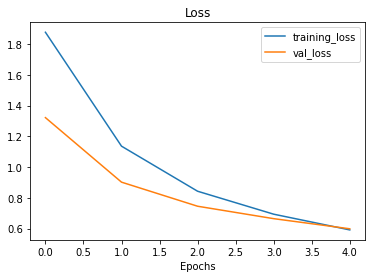

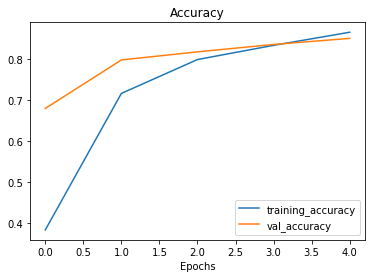

In [59]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [60]:
# Define the input shape
import tensorflow as tf
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed = 24
input_tensor = tf.random.normal(input_shape)

print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tesnsor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global averate pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global average pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.28627414 -0.6294608   1.0321909 ]
   [-0.94491327  0.11749531  0.30722588]
   [ 0.07987318 -0.56806654  0.21226443]
   [-0.08227621 -0.4237943   0.19876935]]

  [[ 1.0822864  -0.34453467 -0.3707651 ]
   [-1.5719405   0.576496    1.9727931 ]
   [ 2.3371885   1.2752708  -0.8251253 ]
   [ 1.1925492  -0.28820628 -0.4012935 ]]

  [[ 1.4979389  -0.60815924 -0.33273292]
   [-0.6698711   2.280097    0.5161065 ]
   [-1.2154692  -0.45123082  0.1072457 ]
   [-0.99290305 -0.13800986 -0.5346481 ]]

  [[-1.1124966  -1.1769943   0.20254841]
   [-1.1762257  -0.5017128  -0.5911657 ]
   [ 1.0893244   0.06516669  1.898234  ]
   [ 0.74517107 -0.8854194  -1.2935197 ]]]]

2D global averate pooled random tensor:
 [[ 0.03403188 -0.10631644  0.13113299]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global average pooled 2D tensor: (1, 3)


In [61]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.03403188, -0.10631644,  0.13113299]], dtype=float32)>

**Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D` ... and see what happens

In [62]:
# Using globalMaxPool2D
tf.reduce_max(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[2.3371885, 2.280097 , 1.9727931]], dtype=float32)>

In [63]:
global_max_pooled_layer = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(global_max_pooled_layer)

tf.Tensor([[2.3371885 2.280097  1.9727931]], shape=(1, 3), dtype=float32)


>**Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained model outputs a feature vector (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of for our own specific problem.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learing on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

**Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Geting and preprocessing data for model_1

In [64]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# unzip data
unzip_data("10_food_classes_1_percent.zip")

--2022-07-04 08:05:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 209.85.147.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   113MB/s    in 1.1s    

2022-07-04 08:05:57 (113 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [65]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [66]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

In [67]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmenation right into our models, we can use the layers inside:

* `tf.keras.layers.experiment.preprocessing()` 

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation

Off the top our of heads, after reading the docs, the benefit of using data augmenation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [68]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizonal flipping, rotations, zooms ...
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescale(1/255.) # Keep for models like ResNet50V2 but EfficientNet's having rescale built-in                                    
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

(-0.5, 463.5, 481.5, -0.5)

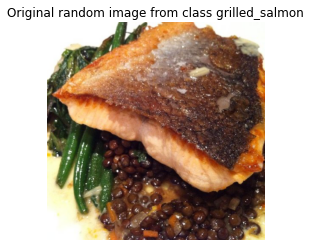

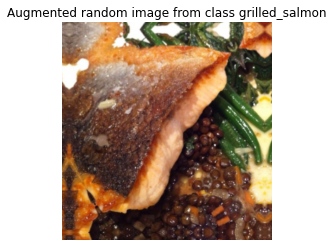

In [69]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(img/255., training=True)
plt.figure()
plt.imshow(augmented_img)
plt.title(f"Augmented random image from class {target_class}")
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [70]:
# Setup input shape and base model, freezing the base model layers
IMG_SIZE = (224, 224)
input_shape = IMG_SIZE + (3,)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape,
                      name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax",
                       name="output_layer")(x)

# Make a model using the input and output
model_1 = keras.Model(inputs, outputs)                       

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220704-080603
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.3752 - accuracy: 0.1286 - val_loss: 2.2208 - val_accuracy: 0.1924
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1725 - accuracy: 0.1714 - val_loss: 2.1108 - val_accuracy: 0.2599
Epoch 3/5
3/3 [==============================] - 3s 2s/step - loss: 2.0198 - accuracy: 0.3143 - val_loss: 1.9842 - val_accuracy: 0.3569
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7973 - accuracy: 0.5571 - val_loss: 1.9142 - val_accuracy: 0.4128
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6526 - accuracy: 0.6143 - val_loss: 1.8246 - val_accuracy: 0.4753


In [71]:
# Check out a model summary
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [72]:
# Evaluate on the full dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 79ms/step - loss: 1.8327 - accuracy: 0.4788


[1.8326722383499146, 0.4787999987602234]

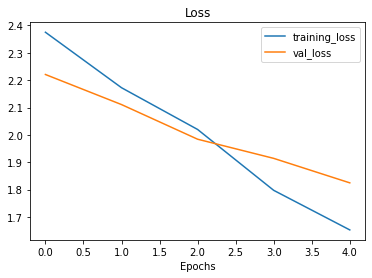

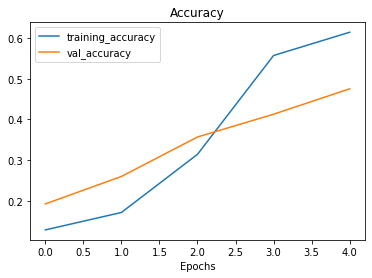

In [73]:
# How do the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning on 10% of the data with data augmentation

In [74]:
# Get the helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-04 08:06:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-04 08:06:42 (77.5 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [75]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [76]:
# Get 10% of data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

--2022-07-04 08:06:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M  47.9MB/s    in 3.2s    

2022-07-04 08:06:46 (50.9 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [77]:
# Set data input
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [78]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmenation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),  # 0.2 is a good default value
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  #preprocessing.Rescaling(1/255.)  # for ResNet50V2 without a built in scaled layer                                
], name="data_augmentation")

In [79]:
from gc import callbacks
# Set-up input shape and base model, freezing the base model's layer
input_shape = IMG_SIZE + (3,)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=input_shape,
                           name="input_layer")

# Add in data augmenation sequential model as a layer
x = data_augmentation(inputs)

# Add the inputs to the base model
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create the model using inputs and outputs
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_10_percent_augmented = model_2.fit(train_data_10_percent,
                                           epochs=5,
                                           steps_per_epoch=len(train_data_10_percent),
                                           validation_data=test_data,
                                           validation_steps=int(0.25*len(test_data)),
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_leraning",
                                                                                  experiment_name="10_percent_data_aug")])

Saving TensorBoard log files to: transfer_leraning/10_percent_data_aug/20220704-080652
Epoch 1/5
24/24 [==============================] - 13s 317ms/step - loss: 2.0092 - accuracy: 0.3213 - val_loss: 1.4958 - val_accuracy: 0.6414
Epoch 2/5
24/24 [==============================] - 7s 285ms/step - loss: 1.3528 - accuracy: 0.6707 - val_loss: 1.0929 - val_accuracy: 0.7401
Epoch 3/5
24/24 [==============================] - 10s 405ms/step - loss: 1.0657 - accuracy: 0.7427 - val_loss: 0.8555 - val_accuracy: 0.7977
Epoch 4/5
24/24 [==============================] - 7s 252ms/step - loss: 0.8914 - accuracy: 0.7640 - val_loss: 0.7696 - val_accuracy: 0.8026
Epoch 5/5
24/24 [==============================] - 7s 296ms/step - loss: 0.8166 - accuracy: 0.7893 - val_loss: 0.7146 - val_accuracy: 0.8043


In [80]:
# Evaluate on the full dataset
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.7038 - accuracy: 0.8084


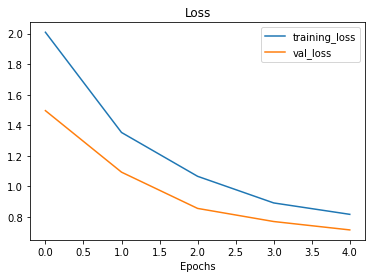

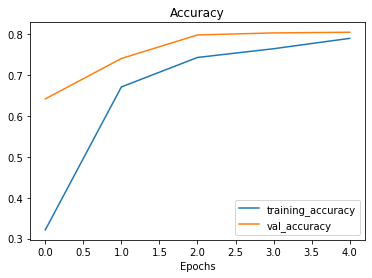

In [81]:
# Plot the loss curve
plot_loss_curves(history_10_percent_augmented)

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [82]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq="epoch",  # save every epoch
                                                        verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [83]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220704-080751
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.7208 - accuracy: 0.8240
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 7s 267ms/step - loss: 0.7208 - accuracy: 0.8240 - val_loss: 0.6524 - val_accuracy: 0.8158
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.8107
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 6s 230ms/step - loss: 0.6757 - accuracy: 0.8107 - val_loss: 0.6190 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.6176 - accuracy: 0.8453
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 7s 274ms/step - loss: 0.6176 - accuracy: 0.8453 - val_loss: 0.6002 - val_accuracy: 0.8207
Epoc

In [84]:
# Check model 2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 0.5655 - accuracy: 0.8360


[0.5654925107955933, 0.8360000252723694]

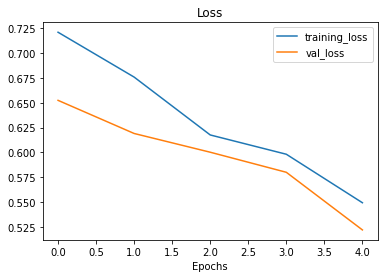

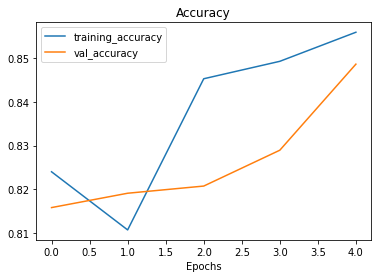

In [85]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

loading in checkpointed weights returns a model to a specific checkpoint

In [86]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [87]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 85ms/step - loss: 0.5655 - accuracy: 0.8360


In [88]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
print("original weights:", results_10_percent_data_aug)
print("loaded weights:  ", loaded_weights_model_results)

original weights: [0.5654925107955933, 0.8360000252723694]
loaded weights:   [0.565492570400238, 0.8360000252723694]


In [89]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [90]:
# Check the difference between 2 results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-5.96046448e-08  0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

>**Note:** So fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [91]:
# Layers in loaded model
model_2.layers

In [92]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe1f7667f50> True
<keras.engine.sequential.Sequential object at 0x7fe1f7402cd0> True
<keras.engine.functional.Functional object at 0x7fe1f70eda90> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fe1f973a110> True
<keras.layers.core.dense.Dense object at 0x7fe1f70e64d0> True


In [93]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [94]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [95]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models everytime we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x
                metrics=["accuracy"])

>**Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a rule of thumb is at least 10x (though differntsource will claim other values). A good resource for information on this is the ULMFiT paper: https://arxiv.org/abs/1801.06146

In [96]:
# Check which layers are tunable (Trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [97]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variable are there?
print(len(model_2.trainable_variables))

12


In [98]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],  # start training from last previous epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])  

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220704-080857
Epoch 5/10
24/24 [==============================] - 16s 333ms/step - loss: 0.4930 - accuracy: 0.8573 - val_loss: 0.5088 - val_accuracy: 0.8273
Epoch 6/10
24/24 [==============================] - 7s 280ms/step - loss: 0.4204 - accuracy: 0.8667 - val_loss: 0.5053 - val_accuracy: 0.8421
Epoch 7/10
24/24 [==============================] - 6s 230ms/step - loss: 0.3717 - accuracy: 0.8933 - val_loss: 0.4897 - val_accuracy: 0.8372
Epoch 8/10
24/24 [==============================] - 7s 276ms/step - loss: 0.3284 - accuracy: 0.9160 - val_loss: 0.4704 - val_accuracy: 0.8355
Epoch 9/10
24/24 [==============================] - 5s 204ms/step - loss: 0.3051 - accuracy: 0.9080 - val_loss: 0.4625 - val_accuracy: 0.8454
Epoch 10/10
24/24 [==============================] - 6s 247ms/step - loss: 0.2564 - accuracy: 0.9307 - val_loss: 0.5208 - val_accuracy: 0.8322


In [99]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.5158 - accuracy: 0.8296


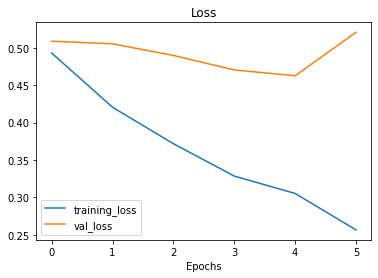

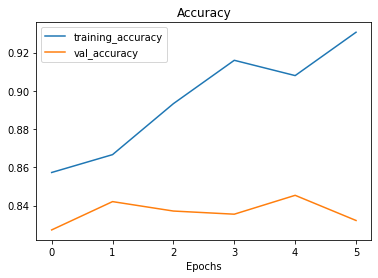

In [100]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (ex before and after fine tuning)

In [101]:
import matplotlib.pyplot as plt

# Let's create a function to compare training histories
def compare_history(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow history object
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

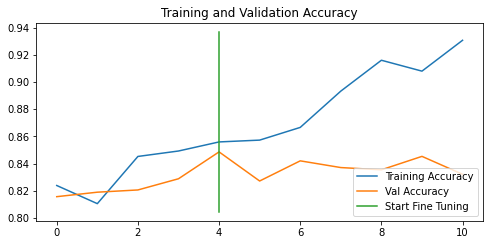

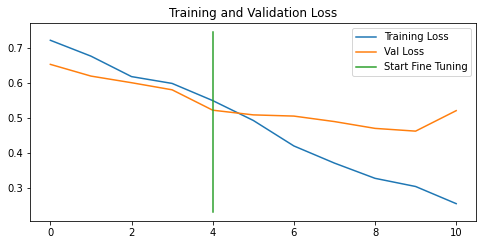

In [102]:
compare_history(history_10_percent_data_aug,
                history_fine_10_percent_data_aug,
                initial_epochs=5)

## Model 4: Fine-tuning and existing model on all of the data

In [103]:
# Get the helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-07-04 08:10:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.4’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-04 08:10:00 (102 MB/s) - ‘helper_functions.py.4’ saved [10246/10246]

--2022-07-04 08:10:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 172.217.214.128, 172.253.114.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

In [104]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [105]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.

In [106]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this...

In [107]:
# Evaluate model 2 (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.5158 - accuracy: 0.8296


[0.5157526135444641, 0.8295999765396118]

In [108]:
results_fine_tune_10_percent

[0.5157526135444641, 0.8295999765396118]

To train a fine-tuning model (model_4) we need to revert model_2 back to its reature extraction weights.

In [109]:
# Load weights from checkpoint, that way we can fine-tune from the same state the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [110]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.5655 - accuracy: 0.8360


[0.5654925107955933, 0.8360000252723694]

In [111]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.5654925107955933, 0.8360000252723694]

Alright, the previous steps seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weight using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we've going to use all of the data (model_4).

In [112]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [113]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer, layer.name, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7fe1f7667bd0> input_4 False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fe1f7667250> rescaling_3 False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7fe1f7642550> normalization_3 False
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7fe1f742ecd0> stem_conv_pad False
4 <keras.layers.convolutional.Conv2D object at 0x7fe1f7425a50> stem_conv False
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe1f742ebd0> stem_bn False
6 <keras.layers.core.activation.Activation object at 0x7fe1f74c4250> stem_activation False
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7fe1f74c9ed0> block1a_dwconv False
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe1f74c4390> block1a_bn False
9 <keras.layers.core.activation.Activation object at 0x7fe1f74d6f50> block1a_activation False
10 <keras.layers.pooling.GlobalAveragePooli

In [114]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25*len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220704-081032
Epoch 5/10
235/235 [==============================] - 46s 165ms/step - loss: 0.6885 - accuracy: 0.7764 - val_loss: 0.4287 - val_accuracy: 0.8470
Epoch 6/10
235/235 [==============================] - 32s 134ms/step - loss: 0.5759 - accuracy: 0.8113 - val_loss: 0.3968 - val_accuracy: 0.8701
Epoch 7/10
235/235 [==============================] - 30s 128ms/step - loss: 0.5117 - accuracy: 0.8343 - val_loss: 0.3789 - val_accuracy: 0.8832
Epoch 8/10
235/235 [==============================] - 30s 127ms/step - loss: 0.4687 - accuracy: 0.8477 - val_loss: 0.3742 - val_accuracy: 0.8783
Epoch 9/10
235/235 [==============================] - 30s 127ms/step - loss: 0.4345 - accuracy: 0.8587 - val_loss: 0.3508 - val_accuracy: 0.8914
Epoch 10/10
235/235 [==============================] - 32s 133ms/step - loss: 0.4136 - accuracy: 0.8685 - val_loss: 0.3522 - val_accuracy: 0.8898


In [115]:
# Let's evaluate on all data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 73ms/step - loss: 0.3247 - accuracy: 0.8952


[0.32471033930778503, 0.8952000141143799]

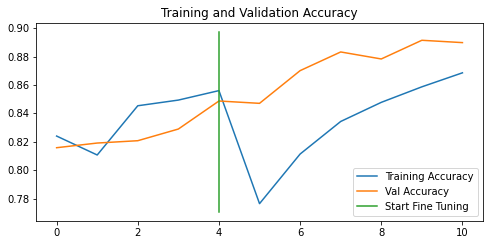

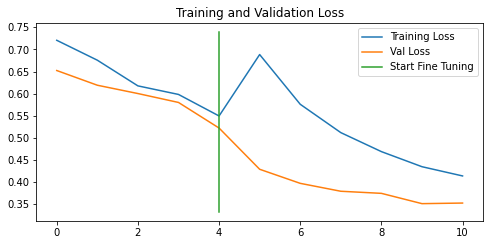

In [116]:
# How did fine-tuning go with more data?
compare_history(original_history=history_10_percent_data_aug,
                new_history=history_fine_10_classes_full,
                initial_epochs=5)

## Viewing our experiment data on TensorBoard

>**Note:** Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not uploaded!

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot # exits the uploader once its finished uploading

My TensorBoard experiments are available at: https://tensorboard.dev/experiment/oY13Jp3GTnC1dr2jZ64DlA/

In [ ]:
# View all of your uploaded TensorBoard.dev
!tensorboard dev list

In [ ]:
# To delete  an experiment
#!tensorboard dev delete --experiment_id id_input_here